# Part 2
On the assignment link you’ll find an sqlite database called northwind.sqlite. This database originally comes from https://github.com/jpwhite3/northwind-SQLite3 but has been modified. Imaging that you have been hired by this firm to help them summarize and understand how good their employees are in terms of their sales. You’ll write up a report for the company (so they are your audience when writing). Your report will be in the form of an .html notebook.

You should drill down into things like how they’ve done across years, how they do in different regions, etc. Please make sure there is a narrative throughout the report. The actual way you quantify how the employees are doing is up to you to determine (not every group will investigate the same things). Please note that the employees have different roles so not everyone is entirely focused on sales. You’ll want to study the database tables a bit to get an idea about the things you could investigate:

You should provide summary statistics and graphs with corresponding interpretations for the company - no need to do any modeling, just focus on summarizing employee performance in meaningful ways. You’ll need to combine data. You can do the joins, summaries, etc. through pandas or via SQL. There are a couple of tables that are empty, just ignore those. Make sure your report has clear sections for the company representatives to read!

In [35]:
#libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
con = sqlite3.connect("northwind.sqlite")

In [37]:
pd.read_sql("SELECT * FROM sqlite_schema WHERE type = 'table';", con)

,type,name,tbl_name,rootpage,sql
0,table,Categories,Categories,2,CREATE TABLE [Categories]\n( [CategoryID]...
1,table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,CustomerCustomerDemo,CustomerCustomerDemo,28,CREATE TABLE [CustomerCustomerDemo](\n [Cust...
3,table,CustomerDemographics,CustomerDemographics,30,CREATE TABLE [CustomerDemographics](\n [Cust...
4,table,Customers,Customers,32,CREATE TABLE [Customers]\n( [CustomerID] ...
5,table,Employees,Employees,38,CREATE TABLE [Employees]\n( [EmployeeID] ...
6,table,EmployeeTerritories,EmployeeTerritories,68,CREATE TABLE [EmployeeTerritories](\n [Emplo...
7,table,Order Details,Order Details,70,CREATE TABLE [Order Details](\n [OrderID]INT...
8,table,Orders,Orders,92,CREATE TABLE [Orders](\n [OrderID]INTEGER NO...
9,table,Products,Products,128,CREATE TABLE [Products](\n [ProductID]INTEGE...


We first created a large dataframe containing the variables we were interested in useing to asses employee sales. The EmpSales_df is a dataframe merged from three smaller merged dataframes: df1, df2, and df3. 
- The first dataframe, df1, was made by combing  employee details and the territory details from table `Employees` and `EmployeeTerritories` in the SQL schema. 
- df2 merged df1 and relevent details from the `Orders` table. 
- df3 was created by merging df2 and all the information from the `Order Details` table
- df4 finally added Regional Descriptions that Each employee represented

In [69]:
df1 = pd.merge(left = pd.read_sql("SELECT  EmployeeID, Title, LastName, FirstName, Region FROM Employees;", con),
        right = pd.read_sql("SELECT  EmployeeID, TerritoryID FROM EmployeeTerritories;", con),
        how = "inner",
        on = "EmployeeID")

#df2 adds orderID, CustomerID EmployeeID and OrderDate
df2 = pd.merge(left = df1,
              right = pd.read_sql("SELECT OrderID, CustomerID, EmployeeID, OrderDate FROM Orders", con),
              how = "inner",
              on = "EmployeeID")

#df3 adds all the columns from the table 'Order Details'
df3 = pd.merge(left = df2,
               right = pd.read_sql("SELECT * FROM 'Order Details'", con),
               how = "inner",
               on = "OrderID")
# calculate the amount for one product within one order
df3['ProductTotal'] = df3['UnitPrice']*df3['Quantity']*(1-df3['Discount'])
# chage the date to year
df3['OrderYear'] = [x[:4] for x in df3.OrderDate]
df3['OrderMonth']=[x[5:7] for x in df3.OrderDate]
df3 = df3.drop('OrderDate', axis = 1)

#adding Territory and RegionIDs
df4=pd.merge(left=df3,
             right=pd.read_sql("SELECT TerritoryID, RegionID FROM 'Territories'",con),
             how="inner",
             on= "TerritoryID")

#adding region descriptions
EmpSales_df=pd.merge(left=df4,
                     right= pd.read_sql("SELECT * FROM Regions", con),
                     how="inner",
                     on="RegionID")
EmpSales_df.head(1)

,EmployeeID,Title,LastName,FirstName,Region,TerritoryID,OrderID,CustomerID,ProductID,UnitPrice,Quantity,Discount,ProductTotal,OrderYear,OrderMonth,RegionID,RegionDescription
0,1,Sales Representative,Davolio,Nancy,WA,06897,10258,ERNSH,2,15.2,50,0.2,608.0,1996,07,1,Eastern ...


The `AnnualSales_df` was created by grouping orders by employee ids, order year, and order total. The graphical summary can be seen below. Employee 2 (Vice President, Andrew Fuller) and employee 7 (Sales Representitive, Robert King) consistently have a high sales performace. The best sales year was 1997.

In [86]:
# group by EmployeeID and OrderYear
group1_df = pd.DataFrame(zip(EmpSales_df.groupby(['EmployeeID','OrderYear'])['EmployeeID'].unique().astype(int),
                         EmpSales_df.groupby(['EmployeeID', 'OrderYear'])['OrderYear'].unique().astype(int),
                         EmpSales_df.groupby(['EmployeeID', 'OrderYear'])['ProductTotal'].sum()),
                     columns = ['EmployeeID', 'OrderYear','ProductTotal'])
SalesGroup_df=group1_df.rename(columns={'ProductTotal':'AnnualSalesTotal'})

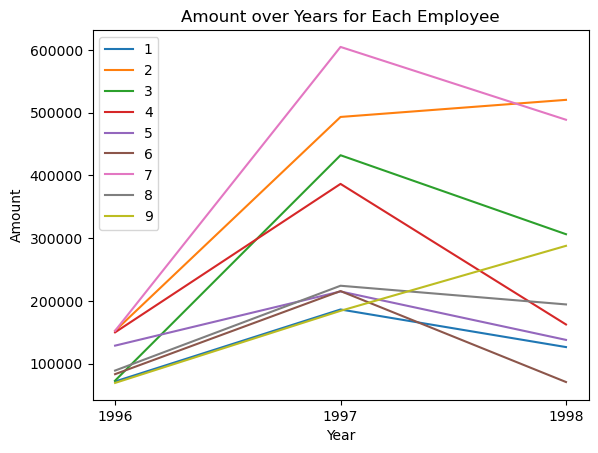

In [88]:
# draw plot
AnnualSales = SalesGroup_df.groupby('EmployeeID')

for name, group in AnnualSales:
  plt.plot(group['OrderYear'].astype(str), group['AnnualSalesTotal'], label = name)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Amount over Years for Each Employee')

plt.show()

Here, we see how the different emplpoyees compare on a five-point summary.Employee #7 has an outlier every year... Wonder what factors may be driving it

In [91]:
# group by OrderID
OrderGroup_df = pd.DataFrame(zip(EmpSales_df.groupby('OrderID')['EmployeeID'].unique().astype(int),
                         EmpSales_df.groupby('OrderID')['OrderYear'].unique().astype(int),
                        EmpSales_df.groupby('OrderID')['ProductTotal'].sum()),
                     columns = ['EmployeeID','OrderYear','ProductTotal'])
OrderGroup_df=OrderGroup_df.rename(columns={'ProductTotal':'OrderTotal'})

1996         AxesSubplot(0.1,0.15;0.235294x0.75)
1997    AxesSubplot(0.382353,0.15;0.235294x0.75)
1998    AxesSubplot(0.664706,0.15;0.235294x0.75)
dtype: object

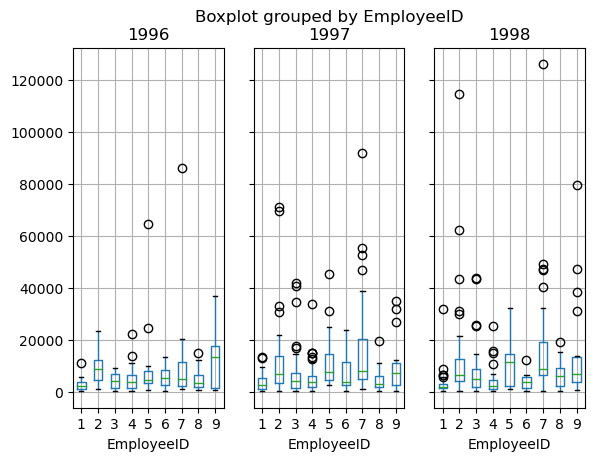

In [92]:
OrderGroup_df.groupby("OrderYear").boxplot(column = "OrderTotal", by = "EmployeeID", layout = [1,3])

In [98]:
RegionGroup_df = pd.DataFrame(zip(EmpSales_df.groupby('OrderID')['EmployeeID'].unique().astype(int),
                         EmpSales_df.groupby('OrderID')['RegionDescription'].unique(),
                        EmpSales_df.groupby('OrderID')['ProductTotal'].sum()),
                     columns = ['EmployeeID','RegionDescription','ProductTotal'])
RegionGroup_df=RegionGroup_df.rename(columns={'ProductTotal':'OrderTotal'})
RegionGroup_df.head(1)

,EmployeeID,RegionDescription,OrderTotal
0,5,[Eastern ...,3080.0


<AxesSubplot: xlabel='OrderYear'>

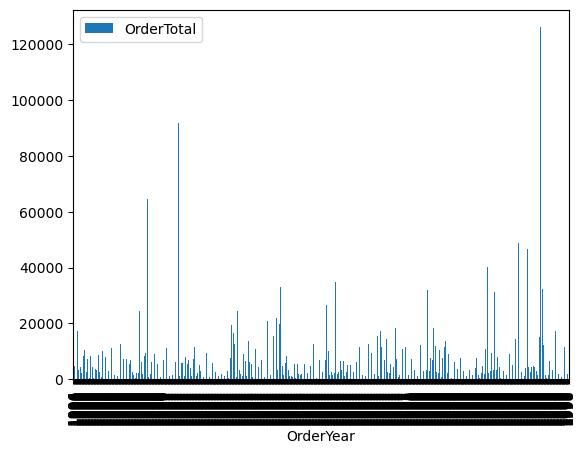

In [119]:
OrderGroup_df.plot.bar(y = "OrderTotal", x = "OrderYear", stacked = True)

ValueError: `bins` must increase monotonically, when an array

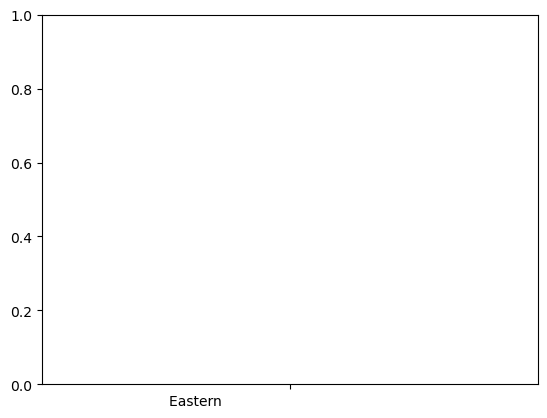

In [100]:
# draw plot
RegionalSales = RegionGroup_df.groupby('EmployeeID')

for name, group in RegionalSales:
  plt.hist(group['RegionDescription'], group['OrderTotal'], label = name)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Amount')
plt.title('Amount over Years for Each Employee')

plt.show()

In [52]:
df3.corr()

/tmp/ipykernel_115/3136175663.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df3.corr()


,EmployeeID,OrderID,ProductID,UnitPrice,Quantity,Discount,ProductTotal
EmployeeID,1.000000,0.036214,-0.030031,0.029128,0.040851,0.090839,0.043003
OrderID,0.036214,1.000000,-0.051024,0.067381,0.028818,-0.001309,0.053332
ProductID,-0.030031,-0.051024,1.000000,-0.027018,0.024959,-0.027179,0.000371
UnitPrice,0.029128,0.067381,-0.027018,1.000000,0.033783,0.009102,0.728812
Quantity,0.040851,0.028818,0.024959,0.033783,1.000000,0.157659,0.492000
Discount,0.090839,-0.001309,-0.027179,0.009102,0.157659,1.000000,0.049634
ProductTotal,0.043003,0.053332,0.000371,0.728812,0.492000,0.049634,1.000000


# Part 3
For part 3, we’re going to redo some of the homework 6 NFL data analysis via spark. (This part should be very easy/short! We’ll use spark SQL and/or pandas-on-spark functionality rather than writing our own MapReduce type code.) 

To do:
• Read in the full nfl data set into spark as a spark data frame
• Use spark SQL to find the mean and standard deviation for the AQ1, AQ2, AQ3, AQ4, AQFinal, HQ1, HQ2, HQ3, HQ4, and HFinal variables
• Find the mean and standardeviation for those same columns but do so for each value of the season variable

Now, repeat the three steps above but use pandas-on-spark rather than spark SQL! As always, you should have a basic narrative flowing through what you are doing and an interpretation of any stats/graphs created.